<a href="https://colab.research.google.com/github/GabrielYamil/TPs_colab/blob/main/TP3/Ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gas Monkey Garage

El programa sincroniza los hilos que representan a los autos pasando por el taller de manera que la playa tiene una cierta capacidad (seis autos) y una vez alcanzada no pouede hacer el ingreso de otro auto hasta que el auto pasa por los diferentes procesos hasta volver a la playa y se lo retire despues va a comprobar si hay lugar en la zona de fosa para ingresarlo y lo mismo pasa con la zona de fosa la cual tiene capacidad (3 autos) y no va liberar los autos hasta que halla espacio en zona de servicio con dos ayudantes para el cambio de aceite y lavado.

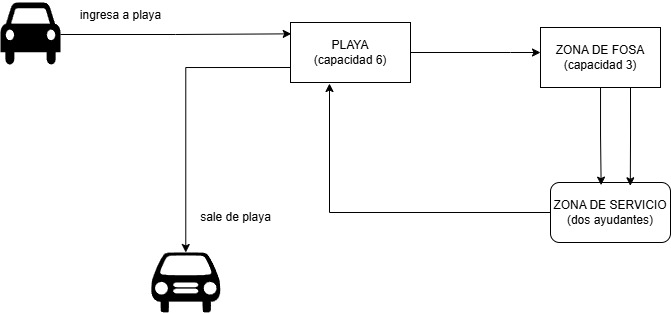

In [2]:
%%writefile GasMonkeyGarage.cpp
#include <iostream>
#include <thread>
#include <chrono>
#include <vector>
#include <memory>
#include <semaphore>
#include <mutex>

using namespace std;

mutex cout_mutex;

class TallerMecanico {
private:
    const int N;

    counting_semaphore<6> espacioPlaya{6};
    counting_semaphore<6> autosParaInspeccion{0};
    counting_semaphore<3> espacioFosa{3};
    counting_semaphore<6> autosParaReparar{0};
    counting_semaphore<2> espacioServicio{2};
    counting_semaphore<1> espacioLavado{1};
    counting_semaphore<1> autoEnReparacion{1};

public:
    TallerMecanico(int n) : N(n) {}

    void richard(int id) {
        espacioPlaya.acquire();
        {
            lock_guard<mutex> lock(cout_mutex);
            cout << "[Auto " << id << "] Richard lo ingresa a la playa." << endl;
        }
        this_thread::sleep_for(chrono::milliseconds(100));
        autosParaInspeccion.release();
    }

    void aaron(int id) {
        autosParaInspeccion.acquire();
        {
            lock_guard<mutex> lock(cout_mutex);
            cout << "[Auto " << id << "] Aaron lo inspecciona." << endl;
        }
        this_thread::sleep_for(chrono::milliseconds(100));
        espacioFosa.acquire();
        autosParaReparar.release();
    }

    void charles(int id) {
        autosParaReparar.acquire();
        autoEnReparacion.acquire();
        {
            lock_guard<mutex> lock(cout_mutex);
            cout << "[Auto " << id << "] ayudante lo traslada a zona de fosa y Charles lo repara." << endl;
        }
        this_thread::sleep_for(chrono::milliseconds(100));
        autoEnReparacion.release();
        espacioServicio.acquire();
        espacioFosa.release();
    }

    void ayudante(int id) {
        {
            lock_guard<mutex> lock(cout_mutex);
            cout << "[Auto " << id << "] Ayudante lo traslada a zona de servicio y cambia el aceite." << endl;
        }
        this_thread::sleep_for(chrono::milliseconds(100));
        espacioServicio.release();

        espacioLavado.acquire();
        {
            lock_guard<mutex> lock(cout_mutex);
            cout << "[Auto " << id << "] Se lava y se lo transporta a playa." << endl;
        }
        this_thread::sleep_for(chrono::milliseconds(100));
        espacioLavado.release();

        espacioPlaya.release();
    }

    void ingresarAuto(int id) {
        richard(id);
        aaron(id);
        charles(id);
        ayudante(id);
    }

    void iniciar() {
        vector<thread> threads;
        for (int i = 0; i < N; ++i) {
            threads.emplace_back(&TallerMecanico::ingresarAuto, this, i + 1);
        }
        for (auto& t : threads) {
            t.join();
        }
        {
            lock_guard<mutex> lock(cout_mutex);
            cout << "Todos los autos fueron atendidos y retirados." << endl;
        }
    }
};

int main(int argc, char* argv[]) {
    if (argc != 2) {
        cerr << "Uso: " << argv[0] << " <N_AUTOS>\n";
        return 1;
    }

    int N = stoi(argv[1]);
    TallerMecanico taller(N);
    taller.iniciar();

    return 0;
}

Writing GasMonkeyGarage.cpp


In [3]:
!ls -la

total 20
drwxr-xr-x 1 root root 4096 May 20 02:23 .
drwxr-xr-x 1 root root 4096 May 20 02:22 ..
drwxr-xr-x 4 root root 4096 May 14 13:38 .config
-rw-r--r-- 1 root root 3057 May 20 02:23 GasMonkeyGarage.cpp
drwxr-xr-x 1 root root 4096 May 14 13:38 sample_data


In [ ]:
!rm GasMonkeyGarage.cpp

In [4]:
!g++ -std=c++20 -pthread GasMonkeyGarage.cpp -o taller

In [5]:
!./taller 20

[Auto 3] Richard lo ingresa a la playa.
[Auto 4] Richard lo ingresa a la playa.
[Auto 5] Richard lo ingresa a la playa.
[Auto 2] Richard lo ingresa a la playa.
[Auto 1] Richard lo ingresa a la playa.
[Auto 6] Richard lo ingresa a la playa.
[Auto 4] Aaron lo inspecciona.
[Auto 3] Aaron lo inspecciona.
[Auto 5] Aaron lo inspecciona.
[Auto 2] Aaron lo inspecciona.
[Auto 1] Aaron lo inspecciona.
[Auto 6] Aaron lo inspecciona.
[Auto 3] ayudante lo traslada a zona de fosa y Charles lo repara.
[Auto 5] ayudante lo traslada a zona de fosa y Charles lo repara.
[Auto 3] Ayudante lo traslada a zona de servicio y cambia el aceite.
[Auto 5] Ayudante lo traslada a zona de servicio y cambia el aceite.
[Auto 2] ayudante lo traslada a zona de fosa y Charles lo repara.
[Auto 3] Se lava y se lo transporta a playa.
[Auto 2] Ayudante lo traslada a zona de servicio y cambia el aceite.
[Auto 1] ayudante lo traslada a zona de fosa y Charles lo repara.
[Auto 5] Se lava y se lo transporta a playa.
[Auto 16] Ric